In [1]:
pip install pandas numpy matplotlib scikit-learn tensorflow statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 7.5 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

# 載入資料集
file_path = "/Users/blue/joanna_test/ML_final/taiwan-surface-temperature/datasets/taiwan_clean_dataset.csv"
data = pd.read_csv(file_path)
data['date'] = pd.to_datetime(data['date'])
data.sort_values('date', inplace=True)

# 切分訓練與測試資料集
train = data[(data['date'] >= '1841-01-01') & (data['date'] <= '1979-12-01')]
test = data[(data['date'] >= '1980-01-01') & (data['date'] <= '2013-09-01')]

# 定義特徵和目標
features = [col for col in data.columns if col not in ['date', 'AverageTemperature']]
target = 'AverageTemperature'

# 測試集依據 CityGroup 切分
city_groups = ['CityGroup_North-East', 'CityGroup_North-West', 'CityGroup_South-East', 'CityGroup_South-West']
test_sets = {group: test[test[group] == 1] for group in city_groups}

FileNotFoundError: [Errno 2] No such file or directory: './taiwan_clean_dataset.csv'

C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.1536
Epoch 2/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0077
Epoch 3/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0073
Epoch 4/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0072
Epoch 5/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0070
Epoch 6/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0069
Epoch 7/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0070
Epoch 8/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0071
Epoch 9/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0068
Epoch 10/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0070
Epoch 11/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0068
Epoch 12/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0068
Epoch 13/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0067
Epoch 14/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0067
Epoch 15/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - lo

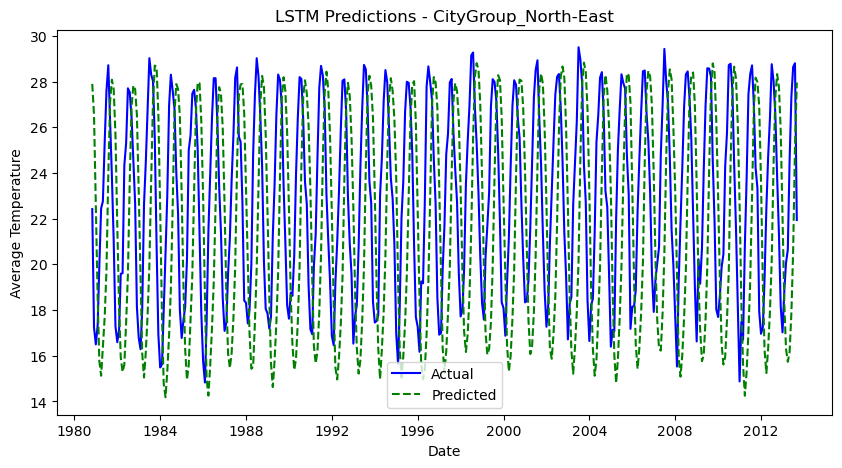

LSTM on CityGroup_North-East: RMSE = 6.0546, MAE = 5.3891
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


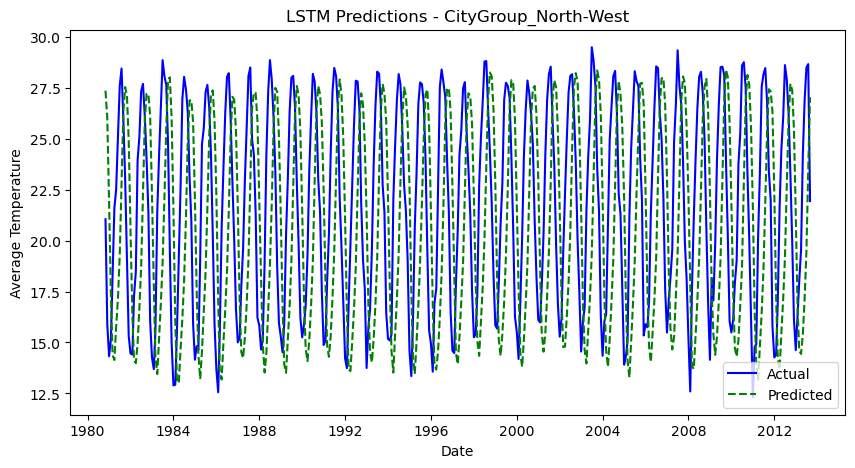

LSTM on CityGroup_North-West: RMSE = 6.7177, MAE = 6.0172
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


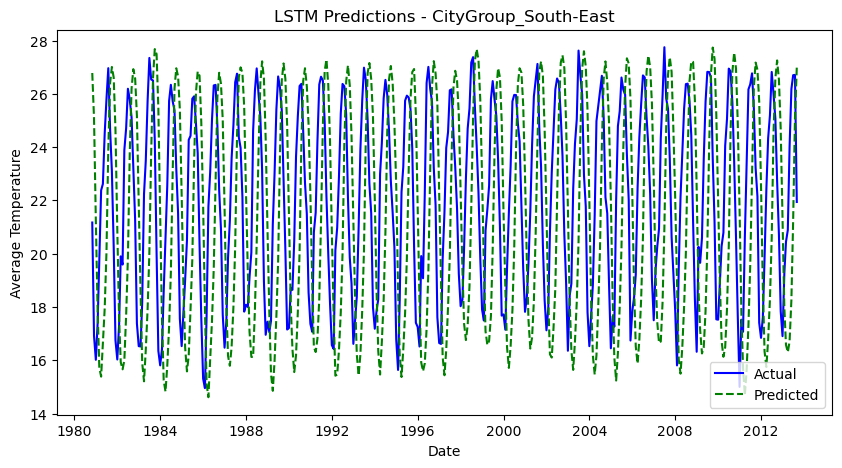

LSTM on CityGroup_South-East: RMSE = 5.2575, MAE = 4.7048
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


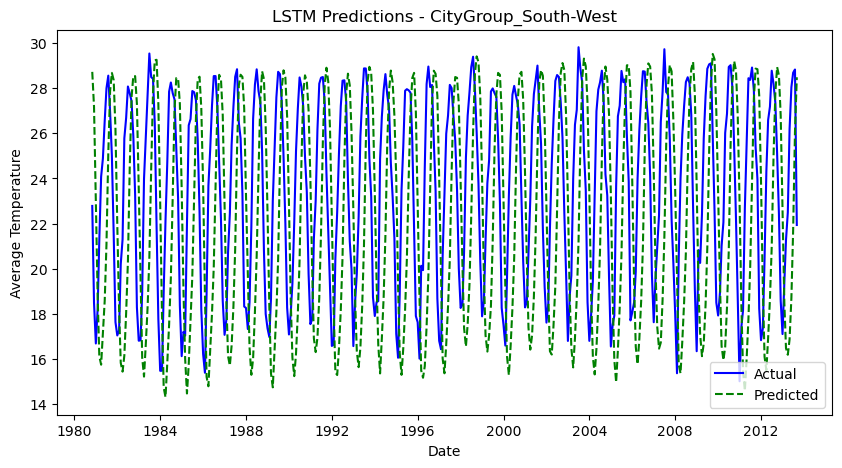

LSTM on CityGroup_South-West: RMSE = 6.3069, MAE = 5.5841


In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 資料預處理：縮放與序列化
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[[target]])
seq_length = 10  # 時間步長

def create_lstm_data(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

X_train, y_train = create_lstm_data(train_scaled, seq_length)

# 定義 LSTM 模型
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=32)

# 測試集預測
def predict_lstm(test_set, scaler, seq_length):
    test_scaled = scaler.transform(test_set[[target]])
    X_test, y_test = create_lstm_data(test_scaled, seq_length)
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
    return y_test, predictions

# 評估 LSTM 模型
for group, test_set in test_sets.items():
    y_test, y_pred = predict_lstm(test_set, scaler, seq_length)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    # 結果圖
    plt.figure(figsize=(10, 5))
    plt.plot(test_set['date'][seq_length:], y_test, label='Actual', color='blue')
    plt.plot(test_set['date'][seq_length:], y_pred, label='Predicted', color='green', linestyle='--')
    plt.title(f'LSTM Predictions - {group}')
    plt.xlabel('Date')
    plt.ylabel('Average Temperature')
    plt.legend()
    plt.show()
    
    print(f"LSTM on {group}: RMSE = {rmse:.4f}, MAE = {mae:.4f}")

C:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


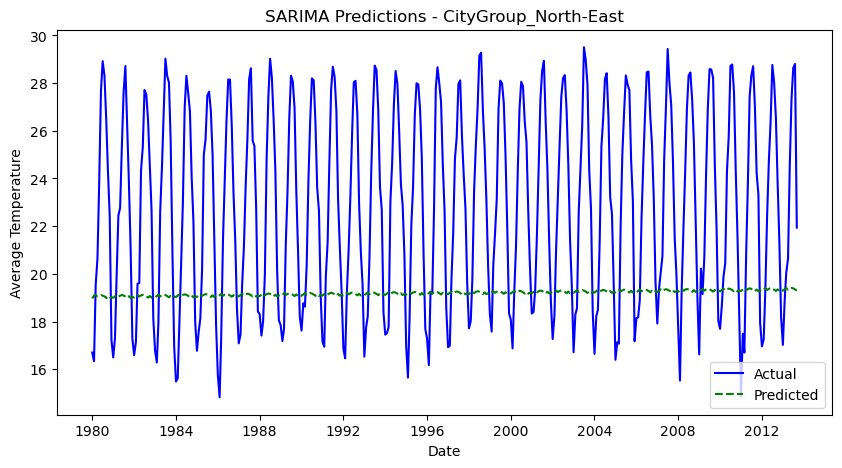

SARIMA on CityGroup_North-East: RMSE = 5.4871, MAE = 4.5204


C:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


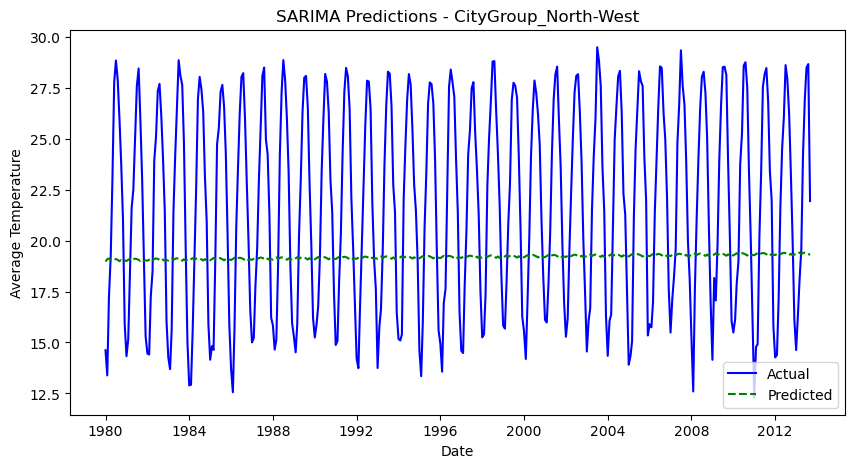

SARIMA on CityGroup_North-West: RMSE = 5.5478, MAE = 4.8259


C:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


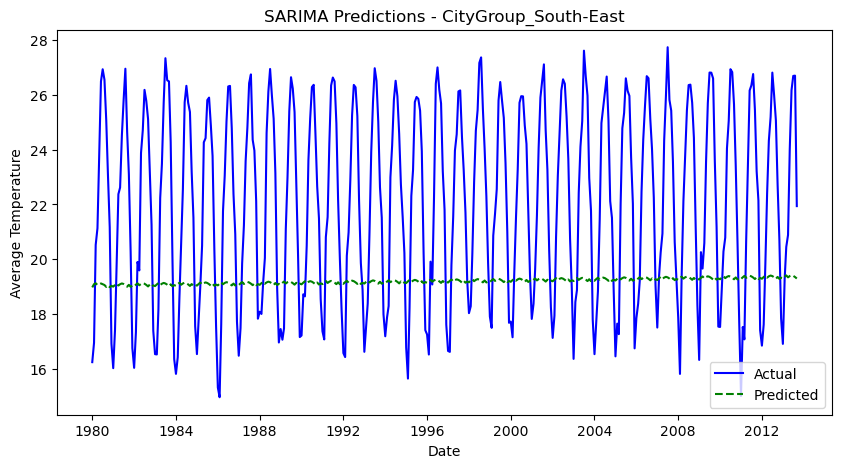

SARIMA on CityGroup_South-East: RMSE = 4.5129, MAE = 3.8196


C:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


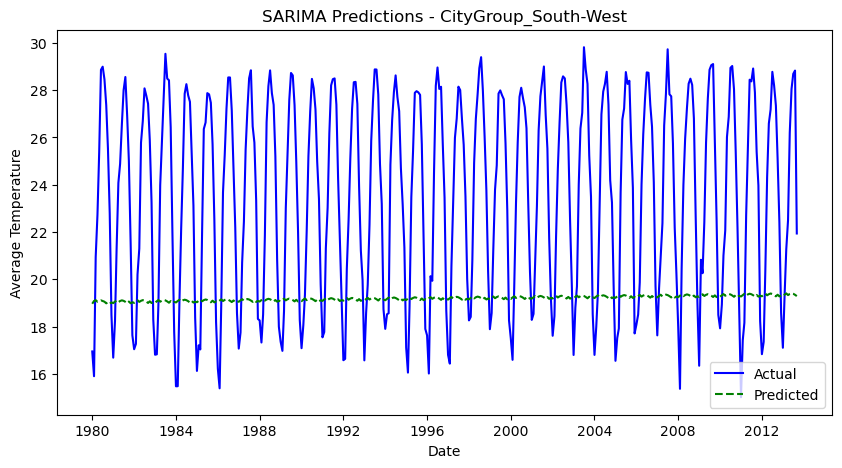

SARIMA on CityGroup_South-West: RMSE = 6.0447, MAE = 5.1070


In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMA 模型訓練與預測
def train_sarima(train_set, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)):
    model = SARIMAX(train_set[target], order=order, seasonal_order=seasonal_order)
    sarima_model = model.fit(disp=False)
    return sarima_model

# 預測與評估 SARIMA 模型
for group, test_set in test_sets.items():
    sarima_model = train_sarima(train)
    predictions = sarima_model.forecast(steps=len(test_set))
    
    # 評估指標
    rmse = np.sqrt(mean_squared_error(test_set[target], predictions))
    mae = mean_absolute_error(test_set[target], predictions)
    
    # 結果圖
    plt.figure(figsize=(10, 5))
    plt.plot(test_set['date'], test_set[target], label='Actual', color='blue')
    plt.plot(test_set['date'], predictions, label='Predicted', color='green', linestyle='--')
    plt.title(f'SARIMA Predictions - {group}')
    plt.xlabel('Date')
    plt.ylabel('Average Temperature')
    plt.legend()
    plt.show()
    
    print(f"SARIMA on {group}: RMSE = {rmse:.4f}, MAE = {mae:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


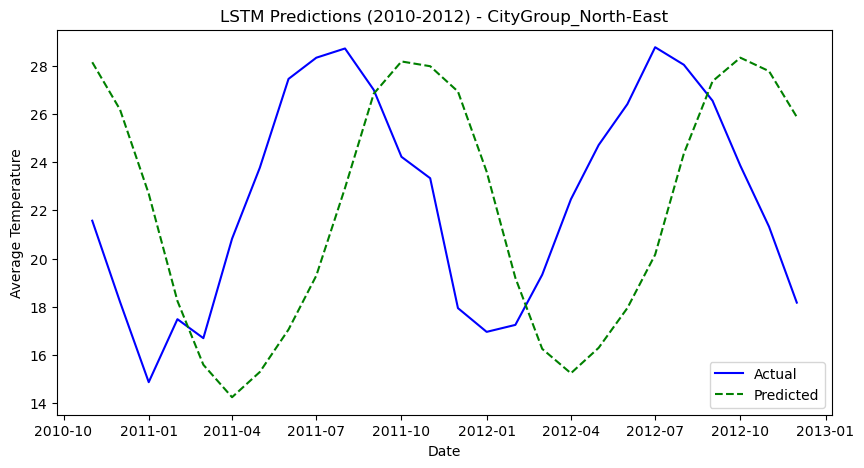

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


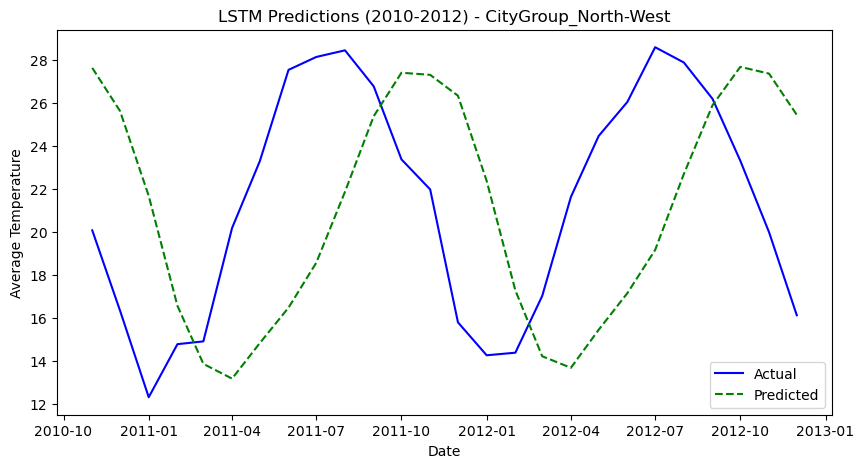

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


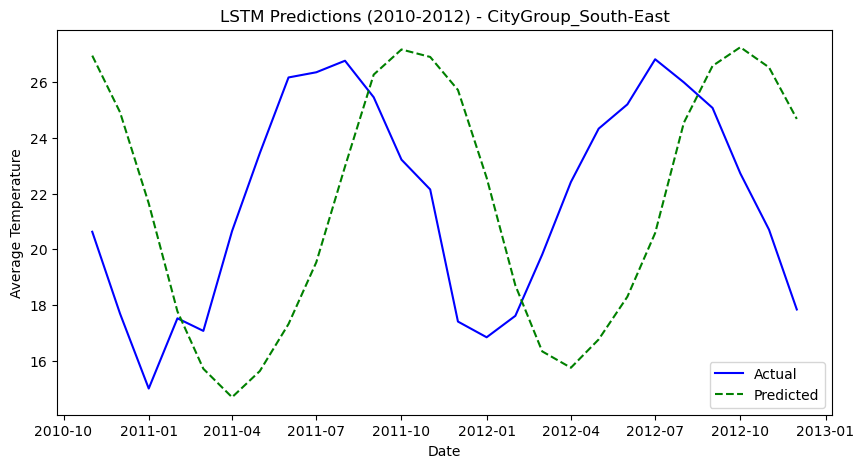

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


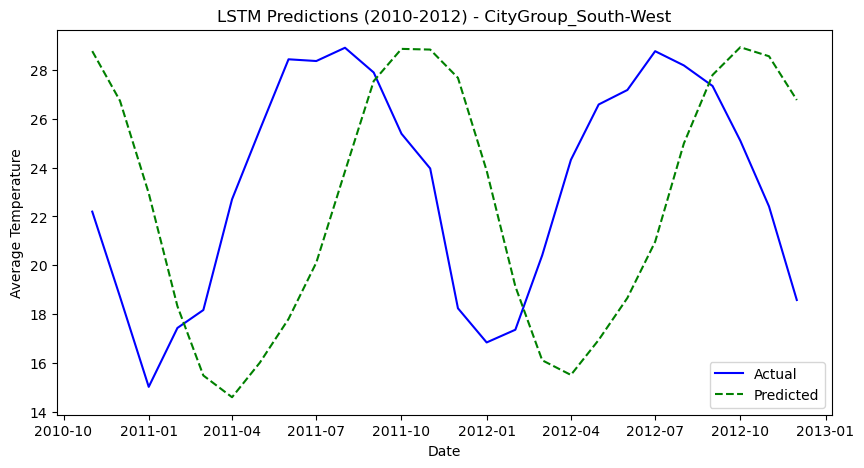

C:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


ValueError: x and y must have same first dimension, but have shapes (26,) and (36,)

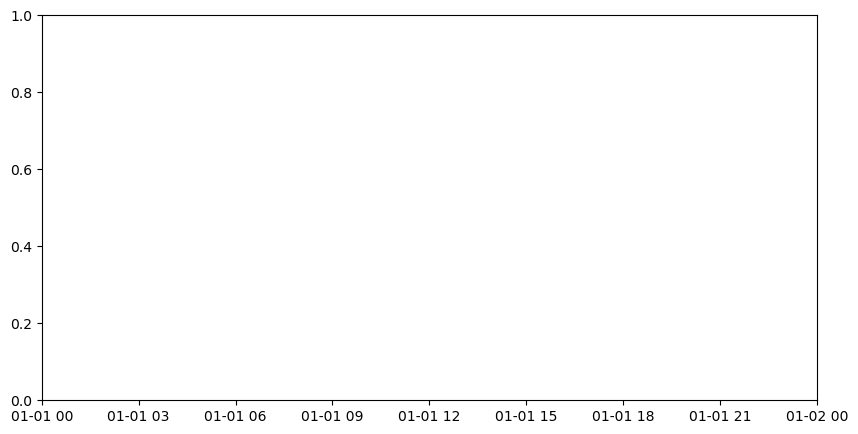

In [14]:
def plot_results_2010_2012(model_name, test_sets, start_date='2010-01-01', end_date='2012-12-31'):
    for group, test_set in test_sets.items():
        filtered_set = test_set[(test_set['date'] >= start_date) & (test_set['date'] <= end_date)]
        if model_name == 'LSTM':
            y_test, y_pred = predict_lstm(filtered_set, scaler, seq_length)
        else:
            sarima_model = train_sarima(train)
            y_pred = sarima_model.forecast(steps=len(filtered_set))
            y_test = filtered_set[target]
        
        plt.figure(figsize=(10, 5))
        plt.plot(filtered_set['date'][seq_length:], y_test, label='Actual', color='blue')
        plt.plot(filtered_set['date'][seq_length:], y_pred, label='Predicted', color='green', linestyle='--')
        plt.title(f"{model_name} Predictions (2010-2012) - {group}")
        plt.xlabel('Date')
        plt.ylabel('Average Temperature')
        plt.legend()
        plt.show()

# 2010-2012 LSTM 結果
plot_results_2010_2012('LSTM', test_sets)

# 2010-2012 SARIMA 結果
plot_results_2010_2012('SARIMA', test_sets)
